In [4]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### First of all, we need to get the parameters of the system

Speaking more specific, we should determine such factors:
    
   * RSSI measurement at 1m (TX power, quite often can be found in documentation)
        - the measurement should be done for different sensors
        - the measurement should be done for several sensors at the same time, to get the picture on how the signals influence each other
        - the measurement should be done for different orientation of the laptop (as it is not known where the ble module is located)
   
Then we can process the received datasets in the following way
   * determine the environmental factors:
  
        - https://hal.archives-ouvertes.fr/hal-01387824/document
        
        - path loss index is calculated only using RSSI measurements, as it affects both transmitter and receiver (it should be calculated for each specific beacon, as it can be afffected even by laptop's screen)
        
         - `n = (RSSI(d0) - RSSI(d)) / 10 * log(d/d0)`
   * then we should come up with a formula that will be used to determine an estimated distance towards specific beacon (backbone of the whole system). 
         - The best outcome possible: come up with some dynamic calibration of it, as it is impossible to reach sufficient accuracy with a general-case formula (RSSI is hugely affected by the environmental propagation)

In [5]:
def get_path_loss_index(tx_benchmark_power: int, RSSI: int,
                        benchmark_distance: float, RSSI_measured_distance: float):
    '''
    determines n - path loss index which depends on the
    propagation environment
    '''

    return (tx_benchmark_power - RSSI) / (10 * math.log(RSSI_measured_distance/benchmark_distance))

In [6]:
def get_distance_no_calibration(RSSI: int, tx_power: int):
    return 0.89976 * (RSSI/tx_power)**7.7095 + 0.111 

def get_distance(RSSI: int, tx_power: int, n: float): 
    '''
    Uses Log-distance path loss model
    '''
    
    return 10**((tx_power -  RSSI) / (10 * n))

       TIME         DEVICE  RSSI
0  12:50:18  SmartParking1   -59
1  12:50:18  SmartParking1   -60
2  12:50:23  SmartParking1   -60
3  12:50:23  SmartParking1   -60
4  12:50:27  SmartParking1   -61


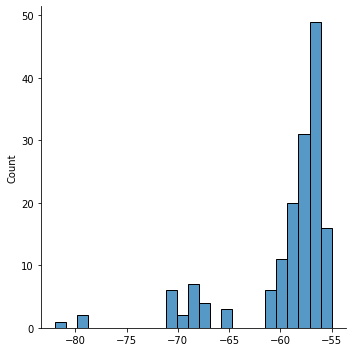

MEAN_POWER=-59.721518987341774
MODE_POWER=-57


In [35]:
def gets_stats(path_to_file: str, device: str):
    df = pd.read_csv(path_to_file, sep=";")
    print(df.head())
    
    sens_rssi = df[df["DEVICE"] == device]["RSSI"].values.tolist()
    sns.displot(sens_rssi)
    plt.show()
    
    MEAN_POWER = np.array(sens_rssi).mean()
    MODE_POWER = stats.mode(sens_rssi)[0][0]
    print(f"{MEAN_POWER=}")
    print(f"{MODE_POWER=}")
    
    return MEAN_POWER
    
tx_benchmark_power = gets_stats("one_meter.csv", "SmartParking1")

One meter to the BLE beacon. Screen is oriented in the opposite direction to the BLE beacon (this is important, as one can see later on)

       TIME         DEVICE  RSSI
0  13:00:23  SmartParking1   -59
1  13:00:23  SmartParking1   -59
2  13:00:26  SmartParking1   -60
3  13:00:26  SmartParking1   -60
4  13:00:28  SmartParking1   -61


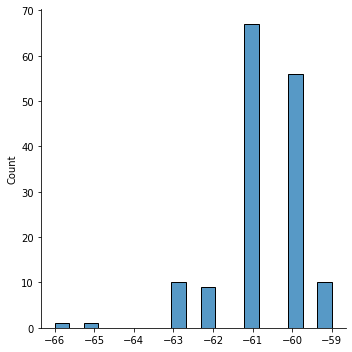

MEAN_POWER=-60.753246753246756
MODE_POWER=-61


In [8]:
two_meters_RSSI = gets_stats("two_meters.csv", "SmartParking1")

The same setup, but the distance is two meters, in order to determine the PATH_LOSS_INDEX.

In [9]:
PATH_LOSS_INDEX = get_path_loss_index(tx_benchmark_power, two_meters_RSSI, 1, 2)

In [10]:
PATH_LOSS_INDEX = round(PATH_LOSS_INDEX, 0) # what if make it integer number

In [11]:
get_distance(two_meters_RSSI, tx_benchmark_power, 1)

2.51188643150958

       TIME         DEVICE  RSSI
0  13:47:00  SmartParking1   -67
1  13:47:00  SmartParking1   -67
2  13:47:05  SmartParking1   -66
3  13:47:05  SmartParking1   -67
4  13:47:06  SmartParking1   -65


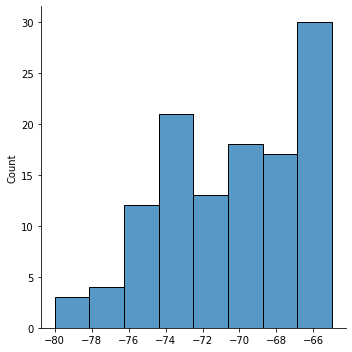

MEAN_POWER=-70.2542372881356
MODE_POWER=-66


In [12]:
one_eighty = gets_stats("one_eighty.csv", "SmartParking1")

In [13]:
get_distance(one_eighty, tx_benchmark_power, get_path_loss_index(tx_benchmark_power, one_eighty, 1, 1.8))

3.870674620778843

As one can see, results are too far from what we want to see there, let's try different kind of setup.
Moreover, in the case of the previous distance estimation, the screen was slighlty rotated (there was a gap, where the direct signals could have reached). Let's try to conduct whole thing with the screen rotated towards the sensor

       TIME         DEVICE  RSSI
0  13:59:28  SmartParking1   -59
1  13:59:28  SmartParking1   -60
2  13:59:33  SmartParking1   -63
3  13:59:33  SmartParking1   -63
4  13:59:36  SmartParking1   -64


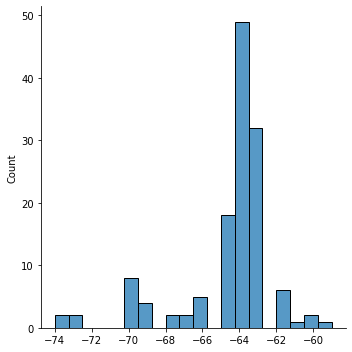

MEAN_POWER=-64.65671641791045
MODE_POWER=-64


In [14]:
one = gets_stats("one_meter_to_screen.csv", "SmartParking1")

       TIME         DEVICE  RSSI
0  13:54:29  SmartParking1   -64
1  13:54:29  SmartParking1   -65
2  13:54:32  SmartParking1   -70
3  13:54:32  SmartParking1   -69
4  13:54:34  SmartParking1   -77


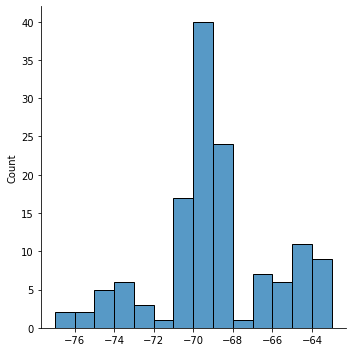

MEAN_POWER=-69.41044776119404
MODE_POWER=-70


In [15]:
two = gets_stats("screen_to_sensor.csv", "SmartParking1")

In [16]:
PATH_LOSS = get_path_loss_index(one, two, 1, 2)
PATH_LOSS

0.8656170245333781

In [17]:
get_distance(one_eighty, one, PATH_LOSS)

1.7023508040251

In [18]:
get_distance_no_calibration(one_eighty, one) # what if to use the
# general case formula, taken from Android Beacon library

1.2516598201812543

## different sensor

       TIME         DEVICE  RSSI
0  06:21:30  SmartParking2   -67
1  06:21:30  SmartParking2   -66
2  06:21:32  SmartParking2   -64
3  06:21:32  SmartParking2   -64
4  06:21:35  SmartParking2   -64


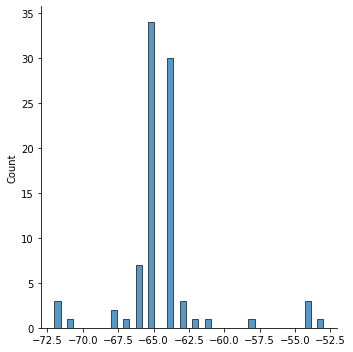

MEAN_POWER=-64.39772727272727
MODE_POWER=-65


-65

In [21]:
gets_stats("dif_one.csv", "SmartParking2")

- we can see that both devices have the same RSSI at the distance of one meter.